### Import Relevant Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
sns.set()
import pyodbc
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Import Data

In [7]:
nRowsRead = 100000
# , nrows=nRowsRead
feature_df = pd.read_csv("Features data set.csv")
sales_df = pd.read_csv("sales data-set.csv")
store_df = pd.read_csv("stores data-set.csv")

In [8]:
feature_df["Date"] = pd.to_datetime(feature_df["Date"], format="%d/%m/%Y")
sales_df["Date"] = pd.to_datetime(sales_df["Date"], format="%d/%m/%Y")

### Combine The Datasets to one Dataframe

In [10]:
sales_date_store = sales_df.groupby(["Date","Store"]).agg({"Weekly_Sales":"sum"})
sales_date_store.sort_index(inplace=True)
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales/10000
sales_date_store.Weekly_Sales = sales_date_store.Weekly_Sales.apply(int)
main_df = pd.merge(feature_df,sales_date_store ,  how='left', on=["Date","Store"])
main_df = pd.merge(main_df,store_df[["Store","Type"]] ,  how='left', on=["Store"])
main_df.head(20)
data_train = main_df[main_df.Weekly_Sales.notnull()]
data_test = main_df[main_df.Weekly_Sales.isnull()]

In [66]:
# init_df = pd.merge(sales_df, feature_df, on=["Store", "Date", "IsHoliday"], how="left")
# main_df = pd.merge(store_df, init_df, on=["Store"], how="left")

In [11]:
main_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Type
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,164.0,A
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,164.0,A
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,161.0,A
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,140.0,A
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,155.0,A


In [12]:
num_samples, num_features = main_df.shape
print(f"The combined dataframe has {num_samples} samples and each sample has {num_features} features.")

The combined dataframe has 8190 samples and each sample has 14 features.


### Check for missing values

In [13]:
main_df.isnull().any()

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
Weekly_Sales     True
Type            False
dtype: bool

In [14]:
for col in main_df.columns:
    count_missn = main_df[col].isnull().sum()
    print(f"The column {col} has {count_missn} null values.")

The column Store has 0 null values.
The column Date has 0 null values.
The column Temperature has 0 null values.
The column Fuel_Price has 0 null values.
The column MarkDown1 has 4158 null values.
The column MarkDown2 has 5269 null values.
The column MarkDown3 has 4577 null values.
The column MarkDown4 has 4726 null values.
The column MarkDown5 has 4140 null values.
The column CPI has 585 null values.
The column Unemployment has 585 null values.
The column IsHoliday has 0 null values.
The column Weekly_Sales has 1755 null values.
The column Type has 0 null values.


### Working on the features

#### Change Column IsHoliday from boolean to integer

In [15]:
main_df["IsHoliday"]  = main_df["IsHoliday"].astype(int)

In [16]:
main_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Type
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,164.0,A
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,164.0,A
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,161.0,A
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,140.0,A
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,155.0,A


In [17]:
main_df.dtypes

Store                    int64
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int32
Weekly_Sales           float64
Type                    object
dtype: object

#### The Type Column

Change The Type Column to categorical

We have three types A, B, C.
A will be assigned to 0, B=1, C=2   respectively 

In [18]:
def cat_store_type(df):
    df_copy = df.copy()
    df_copy.loc[df_copy["Type"] == "A", "Type"] = 0
    df_copy.loc[df_copy["Type"] == "B", "Type"] = 1
    df_copy.loc[df_copy["Type"] == "C", "Type"] = 2
    df_copy["Type"] = df_copy["Type"].astype(int)
    return df_copy

In [19]:
main_df = cat_store_type(main_df)

In [20]:
main_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Type
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,164.0,0
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,164.0,0
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,161.0,0
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,140.0,0
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,155.0,0


#### Date Column

We'll change the date column to year and weekofyear categorical values.

We'll be using WeekOfYear because the final model should be able to predict the weekly sales for a given week

In [21]:
main_df_copy = main_df
main_df_copy["Year"] = main_df_copy.Date.dt.year
main_df_copy["Week_of_Year"] = main_df_copy.Date.dt.weekofyear

# We'll be converting month and day to categorical values
main_df_converted = pd.get_dummies(main_df_copy, columns=["Year", "Week_of_Year"])

# Remove column Date
main_df_converted.drop("Date", axis=1, inplace=True)

In [22]:
main_df_converted.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Week_of_Year_43,Week_of_Year_44,Week_of_Year_45,Week_of_Year_46,Week_of_Year_47,Week_of_Year_48,Week_of_Year_49,Week_of_Year_50,Week_of_Year_51,Week_of_Year_52
0,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,...,0,0,0,0,0,0,0,0,0,0
1,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,...,0,0,0,0,0,0,0,0,0,0
2,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,...,0,0,0,0,0,0,0,0,0,0
3,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,...,0,0,0,0,0,0,0,0,0,0
4,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,...,0,0,0,0,0,0,0,0,0,0


In [23]:
main_df_converted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 69 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store            8190 non-null   int64  
 1   Temperature      8190 non-null   float64
 2   Fuel_Price       8190 non-null   float64
 3   MarkDown1        4032 non-null   float64
 4   MarkDown2        2921 non-null   float64
 5   MarkDown3        3613 non-null   float64
 6   MarkDown4        3464 non-null   float64
 7   MarkDown5        4050 non-null   float64
 8   CPI              7605 non-null   float64
 9   Unemployment     7605 non-null   float64
 10  IsHoliday        8190 non-null   int32  
 11  Weekly_Sales     6435 non-null   float64
 12  Type             8190 non-null   int32  
 13  Year_2010        8190 non-null   uint8  
 14  Year_2011        8190 non-null   uint8  
 15  Year_2012        8190 non-null   uint8  
 16  Year_2013        8190 non-null   uint8  
 17  Week_of_Year_1

### Dealing with Missing Values

#### Using the Iterative Imputer from Sklearn to Remove Missing Data


Cited from Scikit-Learn Documentation:

IterativeImputer class, which models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.



Use only the training data in order to fit the imputer and for validation and test data, the imputer should only be used in order to transform the features. In that way, data leakage shall be avoided.

In [24]:
main_df_converted['CPI'].fillna((main_df_converted['CPI'].mean()), inplace=True)
main_df_converted['Unemployment'].fillna((main_df_converted['Unemployment'].mean()), inplace=True)

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

itt = IterativeImputer()
df = itt.fit_transform(main_df_converted[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]) 
main_df_converted.MarkDown1 = df[:,0]
main_df_converted.MarkDown2 = df[:,1]
main_df_converted.MarkDown3 = df[:,2]
main_df_converted.MarkDown4 = df[:,3]
main_df_converted.MarkDown5 = df[:,4]

### Feature Engineering

#### Splitting the Data Into X and Y

In [29]:
from sklearn.model_selection import train_test_split


data_train = main_df_converted[main_df_converted.Weekly_Sales.notnull()]
data_test = main_df_converted[main_df_converted.Weekly_Sales.isnull()]

# All from Data_Train
X = data_train.drop('Weekly_Sales', axis=1)
y = data_train['Weekly_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

#### Check Features for Importance on Target

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

In [38]:
features_list = list(data_train.drop("Weekly_Sales", axis=1, inplace=False).columns)
X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test)

# To get the scores for the features
for i in range(len(fs.scores_)):
    print(f'Feature {features_list[i]}: {fs.scores_[i]}')

Feature Store: 643.6801825799794
Feature Temperature: 28.18624245663024
Feature Fuel_Price: 0.5048404523293365
Feature MarkDown1: 195.2358547103631
Feature MarkDown2: 11.889274852531285
Feature MarkDown3: 38.04550890943692
Feature MarkDown4: 121.50481698178349
Feature MarkDown5: 178.46763376336207
Feature CPI: 30.202062971332648
Feature Unemployment: 57.66144564493646
Feature IsHoliday: 8.744303887150036
Feature Type: 2880.0354825695636
Feature Year_2010: 0.8966678138898242
Feature Year_2011: 0.1513124905089336
Feature Year_2012: 1.9183403331694306
Feature Year_2013: 0.0
Feature Week_of_Year_1: 1.4266186102653076
Feature Week_of_Year_2: 2.7433184960180026
Feature Week_of_Year_3: 4.00067120572303
Feature Week_of_Year_4: 6.041895705407832
Feature Week_of_Year_5: 0.22369977709863398
Feature Week_of_Year_6: 1.4907369048869907
Feature Week_of_Year_7: 0.05049430609202554
Feature Week_of_Year_8: 0.44423999707631107
Feature Week_of_Year_9: 0.33445993688691894
Feature Week_of_Year_10: 0.0078344

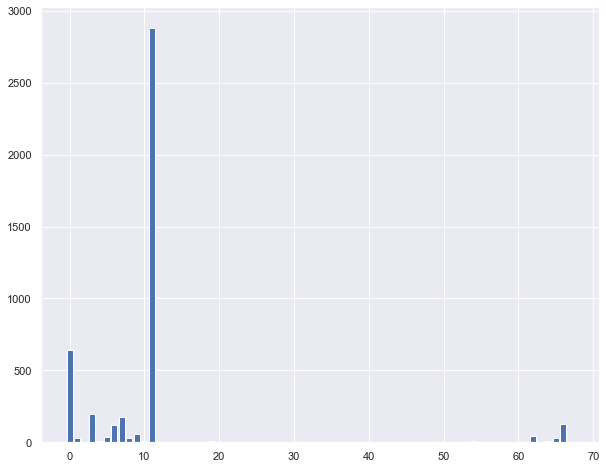

In [37]:
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

###  Modelling

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

In [31]:
regressors = [
    LinearRegression(),
    ElasticNet(),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=3, coef0=2.5),
    Lasso(alpha= 16, random_state=100),
    ElasticNet(alpha=0.8),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    LinearSVR(),
    NuSVR(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
]

name = []
score = []
models = []
rmse = []
i = 0

for regressor in regressors:
    regressor.fit(X_train, Y_train)
    name.append(type(regressor).__name__)
    score.append(regressor.score(X_test, Y_test))
    models.append(regressor)
    rmse.append(np.sqrt(mean_squared_error(regressor.predict(X_test), Y_test)))

In [33]:
df_score = pd.DataFrame(list(zip(name,rmse, score, models)),columns=['name','rmse','score',"model"])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['score'],inplace=True)
df_score

,rmse,score,model
name,,,
KernelRidge,259.952420,-20.002581,"KernelRidge(alpha=0.6, coef0=2.5, kernel='poly..."
LinearSVR,95.640992,-1.842975,LinearSVR()
SVR,53.534792,0.109247,SVR()
NuSVR,53.446827,0.112172,NuSVR()
Lasso,48.538469,0.267754,"Lasso(alpha=16, random_state=100)"
ElasticNet,44.718490,0.378474,ElasticNet()
ElasticNet,44.207383,0.392600,ElasticNet(alpha=0.8)
LinearRegression,40.990781,0.477775,LinearRegression()
RidgeCV,40.975489,0.478165,"RidgeCV(alphas=[0.001, 0.01, 0.1, 1])"


In [34]:
model = df_score.loc["XGBRegressor","model"]
data_test.drop(['Weekly_Sales'],axis=1,inplace=True)
predict = model.predict(data_test)
predict

array([172.12772 , 164.5676  , 163.72073 , ...,  77.77918 ,  77.19886 ,
        77.189606], dtype=float32)